In [1]:
%matplotlib nbagg
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from py4DSTEM.process.braggdiskdetection import get_average_probe_from_ROI, get_probe_kernel_subtrgaussian
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import read, save

from scipy import ndimage
from scipy.spatial import distance

from skimage import filters
from skimage.morphology import disk

import math

In [2]:
filename = 'Bin(2,2,2, 2) of outer enamel.dm4'
datacube = py4DSTEM.file.io.read(filename)

datacube.set_scan_shape(133,131)
datacube.name = 'datacube'

filename = 'Diffraction of vacuum_256x256_50_25.dm3'
from ncempy.io import dm
vacuum = dm.dmReader(filename)

vacuum_sum=np.sum(vacuum['data'])
normalized_data=datacube.data/vacuum_sum

Bin(2,2,2, 2) of outer enamel.dm4 is not a py4DSTEM file.
Couldn't identify input, attempting to read with hyperspy...


In [3]:
realimage=np.average(normalized_data, axis=(2,3))
aveDP = np.average(normalized_data, axis=(0,1))

In [4]:
from skimage import feature
blob=feature.blob_log(aveDP, threshold = 0.0001)
ic=blob[0,0]
jc=blob[0,1]
print("ic is " + str(ic))
print("jc is " + str(jc))

pixel_rad=53.770;

ic is 138.0
jc is 126.0


<IPython.core.display.Javascript object>


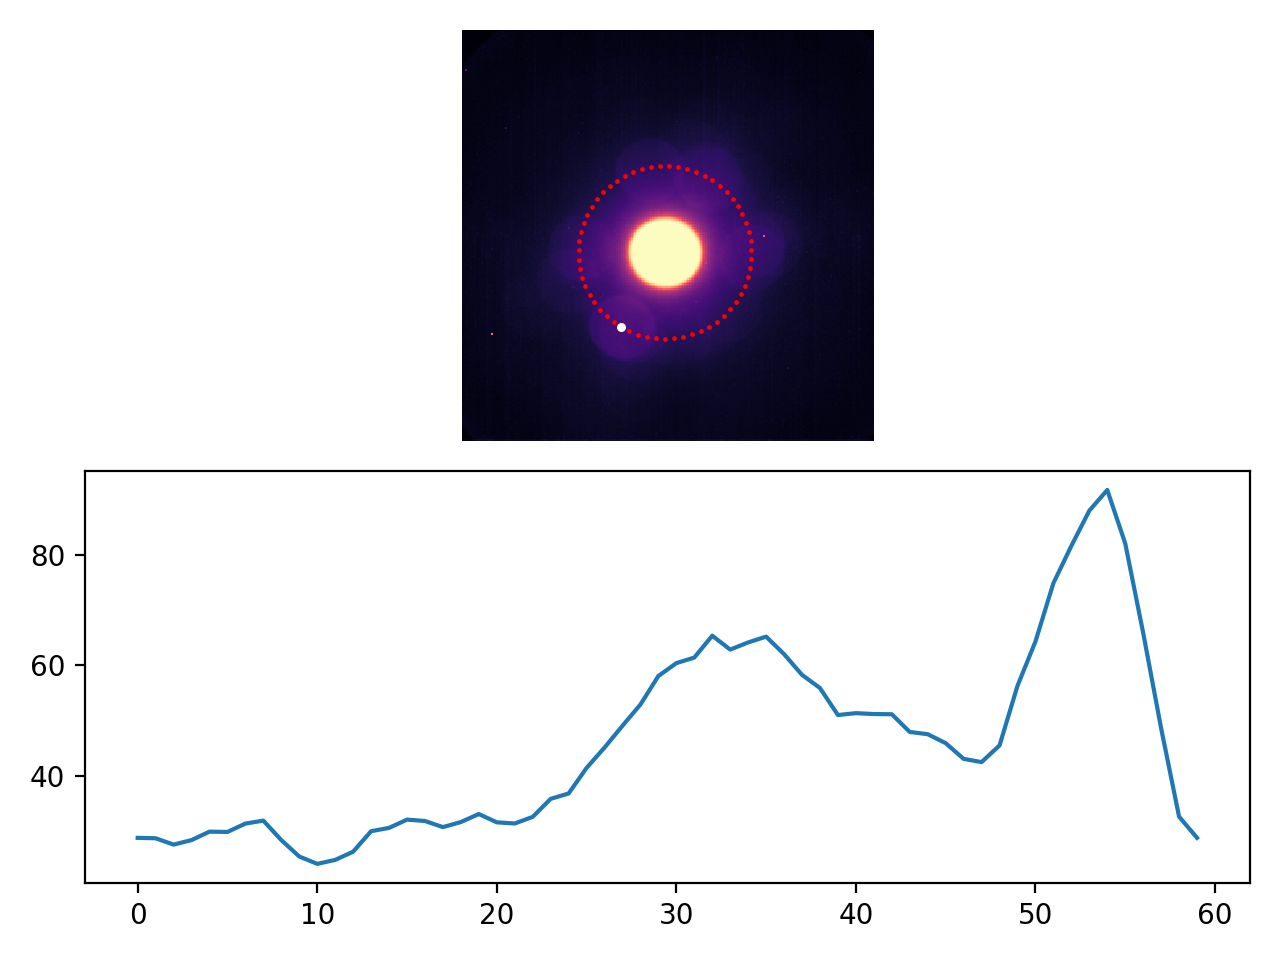

In [5]:
#image=np.average(datacube.data[50:51,50:51,:,:], axis=(0,1))

image=datacube.data[71,121,:,:]

n_dots = 60   # set number of dots
angs = np.linspace(0, 2*np.pi, n_dots)+2.1  # angles to the dots
cx, cy = (jc, ic)  # center of circle
xs, ys = [], []    # for coordinates of points to plot
ra = pixel_rad          # radius of circle

for ang in angs:
    # compute (x,y) for each point
    x = cx + ra*np.cos(ang)
    y = cy + ra*np.sin(ang)
    xs.append(x)   # collect x
    ys.append(y)   # collect y

xs=np.asarray(xs)
ys=np.asarray(ys)

zi=np.zeros((1,len(xs)))
for ii in range(0,len(xs)):
    zi[0,ii] = np.average(image[xs[ii].astype(np.int)-10:xs[ii].astype(np.int)+10, \
                               ys[ii].astype(np.int)-10:ys[ii].astype(np.int)+10])
    

fig, axes = plt.subplots(nrows=2)

axes[0].scatter(xs, ys, c = 'red', s=0.5)  # plot points 
axes[0].scatter(cx + ra*np.cos(2.1), cy + ra*np.sin(2.1), c = 'white', s=5)  # plot points 
axes[0].imshow(aveDP, cmap= plt.cm.magma)
axes[0].axis('off')

axes[1].plot(zi[0,:])
fig.tight_layout()
plt.show()

In [6]:
peak_max=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
remain=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

n_dots = 180   # set number of dots
angs = np.linspace(0, 2*np.pi, n_dots)+2  # angles to the dots
cx, cy = (jc, ic)  # center of circle
ra = pixel_rad 


for i in range(0,datacube.data.shape[0]):
        for j in range(0,datacube.data.shape[1]): 
            #image=np.average(datacube.data[i-3:i+3,j-3:j+3,:,:], axis=(0,1))
            image=normalized_data[i,j,:,:]
            xs, ys = [], []    
      

            for ang in angs:
                x = cx + ra*np.cos(ang)
                y = cy + ra*np.sin(ang)
                xs.append(x)   
                ys.append(y)   

            xs=np.asarray(xs)
            ys=np.asarray(ys)

            zi=np.zeros((1,len(xs)))
            for ii in range(0,len(xs)):
                    zi[0,ii] = np.average(image[xs[ii].astype(np.int)-10:xs[ii].astype(np.int)+10, \
                               ys[ii].astype(np.int)-10:ys[ii].astype(np.int)+10])
            
            max_loc=np.argmax(zi)
            peak_max[i,j]=max_loc
            remain[i,j]=max_loc%90


<IPython.core.display.Javascript object>


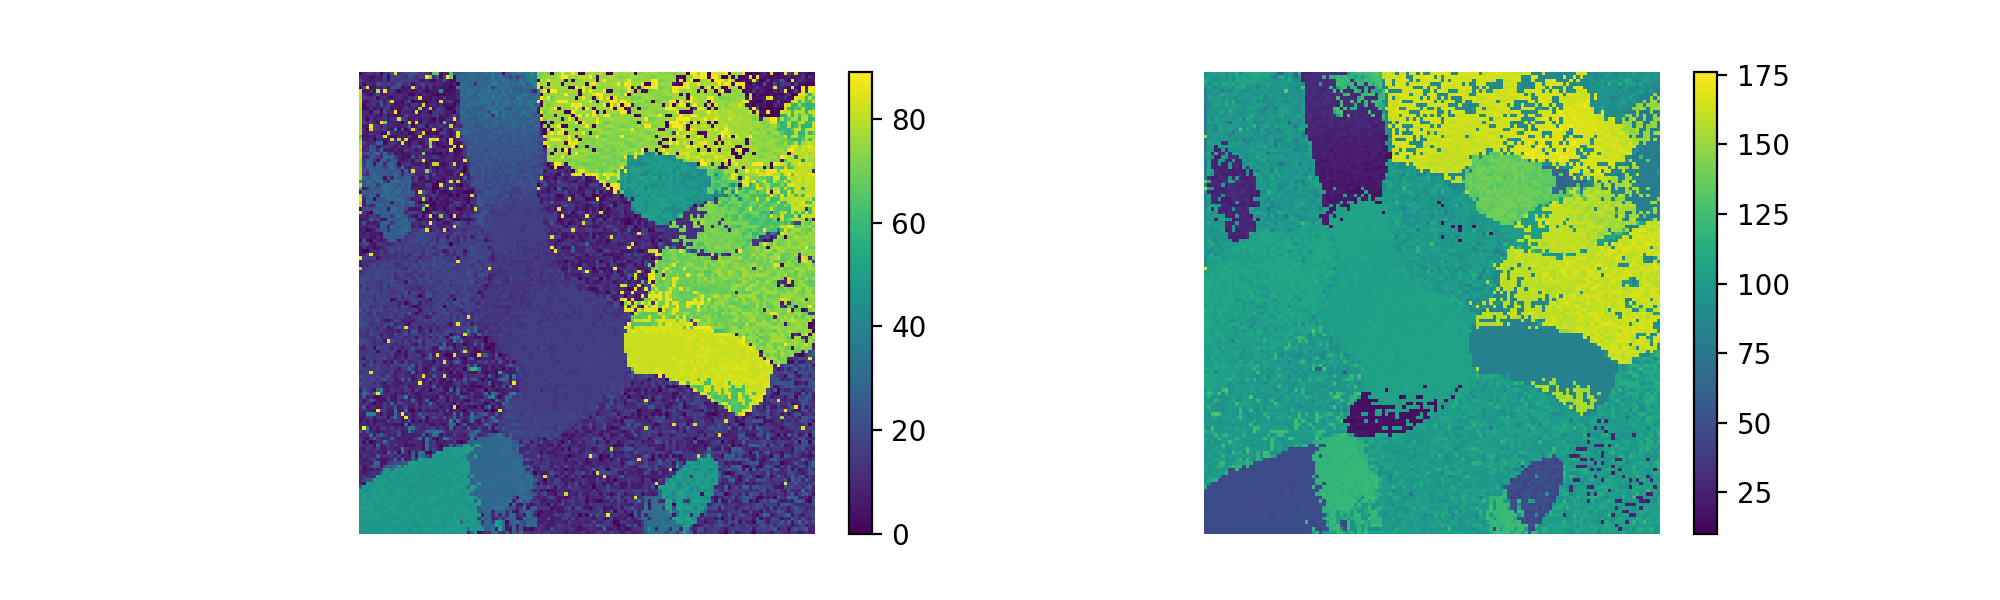

In [7]:
fig,axs = plt.subplots(1,2,figsize=(10,3))
map0=axs[0].imshow(remain, cmap=plt.cm.viridis)  
fig.colorbar(map0, ax=axs[0])

map1=axs[1].imshow(peak_max, cmap=plt.cm.viridis)  
fig.colorbar(map1)

axs[0].axis('off')
axs[1].axis('off')

plt.show()

In [8]:
# #mask diffraction pattern 
# x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
# mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 35 ** 2

# masked_data=normalized_data

# for i in range(0,aveDP.shape[0]):
#     for j in  range(0,aveDP.shape[1]):
#         if mask_circle[i,j]: 
#             #masked_data[:,:,i,j]=.000025
#             masked_data[:,:,i,j]=.0000
# aveDP_masked = np.average(masked_data, axis=(0,1))

# fig,ax=plt.subplots(1,2,figsize=(8,4))
# ax[0].matshow(realimage)
# ax[1].matshow(np.sqrt(aveDP_masked), cmap=plt.cm.inferno)
# ax[0].axis('off')
# ax[1].axis('off')
# plt.show()

<IPython.core.display.Javascript object>


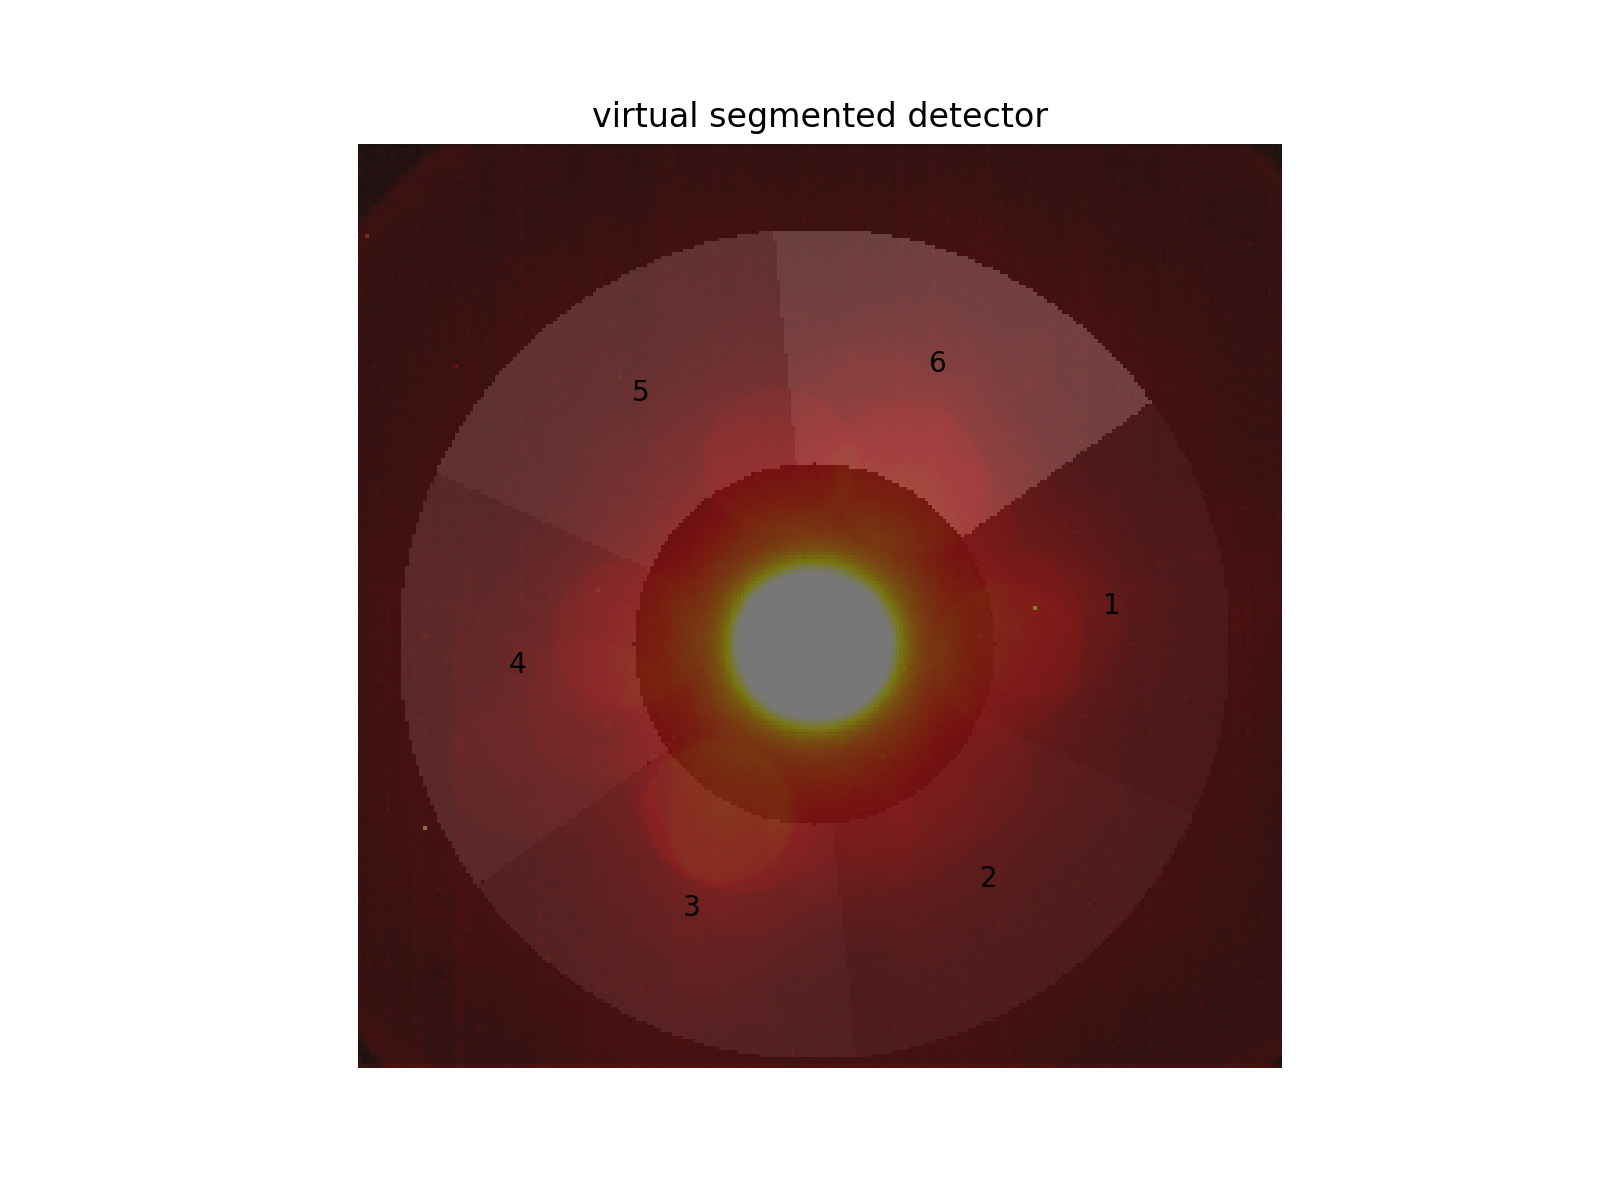

number of elements in mask1 is 5614
number of elements in mask2 is 5615
number of elements in mask3 is 5613
number of elements in mask4 is 5614
number of elements in mask5 is 5615
number of elements in mask6 is 5613


In [9]:
#make a quadrant mask defined by circle centered at origin of diffraciton (ic,jc)
xa, ya = 80, 171

#rotate point by 60° relative to ic, jc (going to use point-point form to define lines for masks)
theta = np.radians(60)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

v=np.array([[xa-jc],[ya-ic]])
v=np.dot(v.T,R).T
xb=v[0,0]+jc
yb=v[1,0]+ic

v=np.dot(v.T,R).T
xc=v[0,0]+jc
yc=v[1,0]+ic

#create masks changing inequalities
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 115 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 50 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) > 0
mask1_6 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask1_COM_6=ndimage.measurements.center_of_mass(mask1_6)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 115 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 50 ** 2
mask_line =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) < 0
mask2_6 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask2_COM_6=ndimage.measurements.center_of_mass(mask2_6)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 115 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 50 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask3_6 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask3_COM_6=ndimage.measurements.center_of_mass(mask3_6)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 115 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 50 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) < 0
mask4_6 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask4_COM_6=ndimage.measurements.center_of_mass(mask4_6)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 115 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 50 ** 2
mask_line =  y - xc - (jc-xc)/(ic-yc) * (x-yc) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask5_6 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask5_COM_6=ndimage.measurements.center_of_mass(mask5_6)


mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 115 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 50 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask6_6 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask6_COM_6=ndimage.measurements.center_of_mass(mask6_6)


#plot masks
fig,ax = plt.subplots(figsize=(8,6))
ax.imshow(mask1_6, alpha=0.3)
ax.text(mask1_COM_6[1],mask1_COM_6[0], '1', ha='center')
ax.imshow(mask2_6, alpha=0.3)
ax.text(mask2_COM_6[1],mask2_COM_6[0],'2', ha='center')
ax.imshow(mask3_6, alpha=0.3)
ax.text(mask3_COM_6[1],mask3_COM_6[0],'3', ha='center')
ax.imshow(mask4_6, alpha=0.3)
ax.text(mask4_COM_6[1],mask4_COM_6[0],'4', ha='center')
ax.imshow(mask5_6, alpha=0.3)
ax.text(mask5_COM_6[1],mask5_COM_6[0],'5', ha='center')
ax.imshow(mask6_6, alpha=0.3)
ax.text(mask6_COM_6[1],mask6_COM_6[0],'6', ha='center')
ax.imshow(np.sqrt(aveDP), cmap=plt.cm.hot, alpha=0.4)
ax.set_title('virtual segmented detector')
ax.axis('off')
plt.show()

#check they are of equal area
print('number of elements in mask1 is ' + str(mask1_6.sum()))
print('number of elements in mask2 is ' + str(mask2_6.sum()))
print('number of elements in mask3 is ' + str(mask3_6.sum()))
print('number of elements in mask4 is ' + str(mask4_6.sum()))
print('number of elements in mask5 is ' + str(mask5_6.sum()))
print('number of elements in mask6 is ' + str(mask6_6.sum()))

In [10]:
def rescale_linear(array, new_min, new_max):
    """Rescale an arrary linearly."""
    minimum, maximum = np.min(array), np.max(array)
    m = (new_max - new_min) / (maximum - minimum)
    b = new_min - m * minimum
    return m * array + b

In [11]:
#calculate Beta 
location_difference=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
for i in range(0,datacube.data.shape[0]):
        for j in range(0,datacube.data.shape[1]):
            filtered_data=filters.rank.mean(rescale_linear(normalized_data[i,j,:,:],0,1), disk(7))
            max1=np.unravel_index(np.ma.array(filtered_data, mask=~mask1_6).argmax(), filtered_data.shape)
            max2=np.unravel_index(np.ma.array(filtered_data, mask=~mask2_6).argmax(), filtered_data.shape)
            max3=np.unravel_index(np.ma.array(filtered_data, mask=~mask3_6).argmax(), filtered_data.shape)
            max4=np.unravel_index(np.ma.array(filtered_data, mask=~mask4_6).argmax(), filtered_data.shape)
            max5=np.unravel_index(np.ma.array(filtered_data, mask=~mask5_6).argmax(), filtered_data.shape)
            max6=np.unravel_index(np.ma.array(filtered_data, mask=~mask6_6).argmax(), filtered_data.shape)
            max1_value=np.sum(np.ma.array(filtered_data, mask=~mask1_6))
            max2_value=np.sum(np.ma.array(filtered_data, mask=~mask2_6))
            max3_value=np.sum(np.ma.array(filtered_data, mask=~mask3_6))
            max4_value=np.sum(np.ma.array(filtered_data, mask=~mask4_6))
            max5_value=np.sum(np.ma.array(filtered_data, mask=~mask5_6))
            max6_value=np.sum(np.ma.array(filtered_data, mask=~mask6_6))         
            if max1_value >= max2_value and max1_value >= max3_value and max1_value >= max4_value and \
            max1_value >= max5_value and max1_value >= max6_value:
                ind1=max1
                ind2=max4
            if max2_value >= max1_value and max2_value >= max3_value and max2_value >= max4_value and \
            max2_value >= max5_value and max2_value >= max6_value:
                ind1=max2
                ind2=max5    
            if max3_value >= max2_value and max3_value >= max1_value and max3_value >= max4_value and \
            max3_value >= max5_value and max3_value >= max6_value:
                ind1=max3
                ind2=max6 
            if max4_value >= max2_value and max4_value >= max3_value and max4_value >= max1_value and \
            max4_value >= max5_value and max4_value >= max6_value:
                ind1=max4
                ind2=max1
            if max5_value >= max2_value and max5_value >= max3_value and max5_value >= max4_value and \
            max5_value >= max1_value and max5_value >= max6_value:
                ind1=max5
                ind2=max2
            if max6_value >= max2_value and max6_value >= max3_value and max6_value >= max6_value and \
            max6_value >= max5_value and max6_value >= max1_value:
                ind1=max6
                ind2=max1
            location_difference[i,j]=distance.euclidean(ind1,[jc,ic])-distance.euclidean(ind2,[jc,ic])


/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


<IPython.core.display.Javascript object>


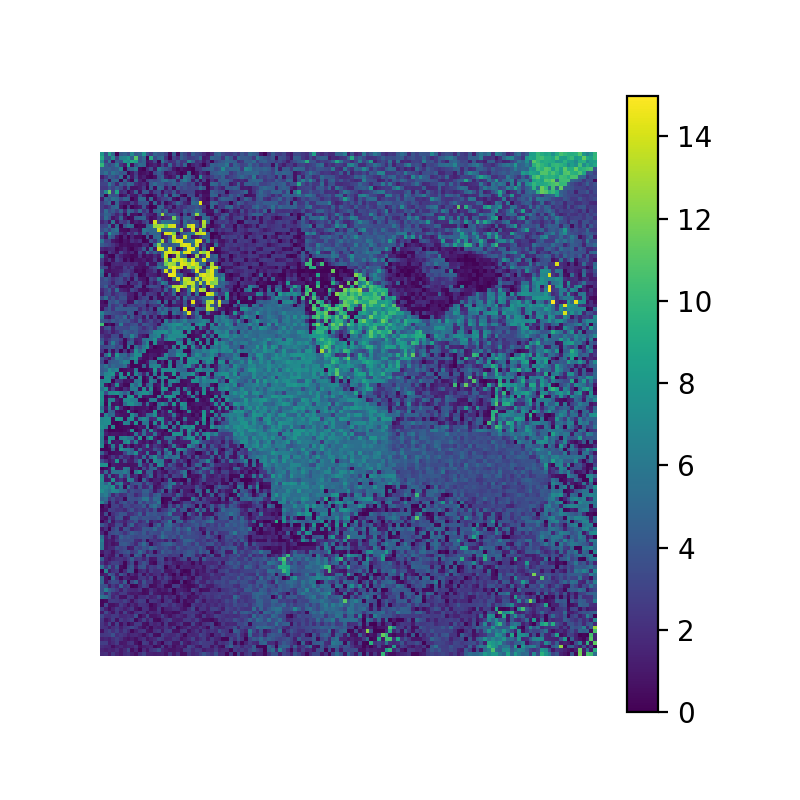

In [12]:
fig,ax = plt.subplots(figsize=(4,4))
image=ax.imshow(np.abs(location_difference/22*3.5), cmap=plt.cm.viridis) #22/3.5 to normalize for mrad, approximate center disk as 2 mrad
fig.colorbar(image, ax=ax)
ax.axis('off')
plt.show()


264897
408872
389895
221674
125463
145119


<IPython.core.display.Javascript object>


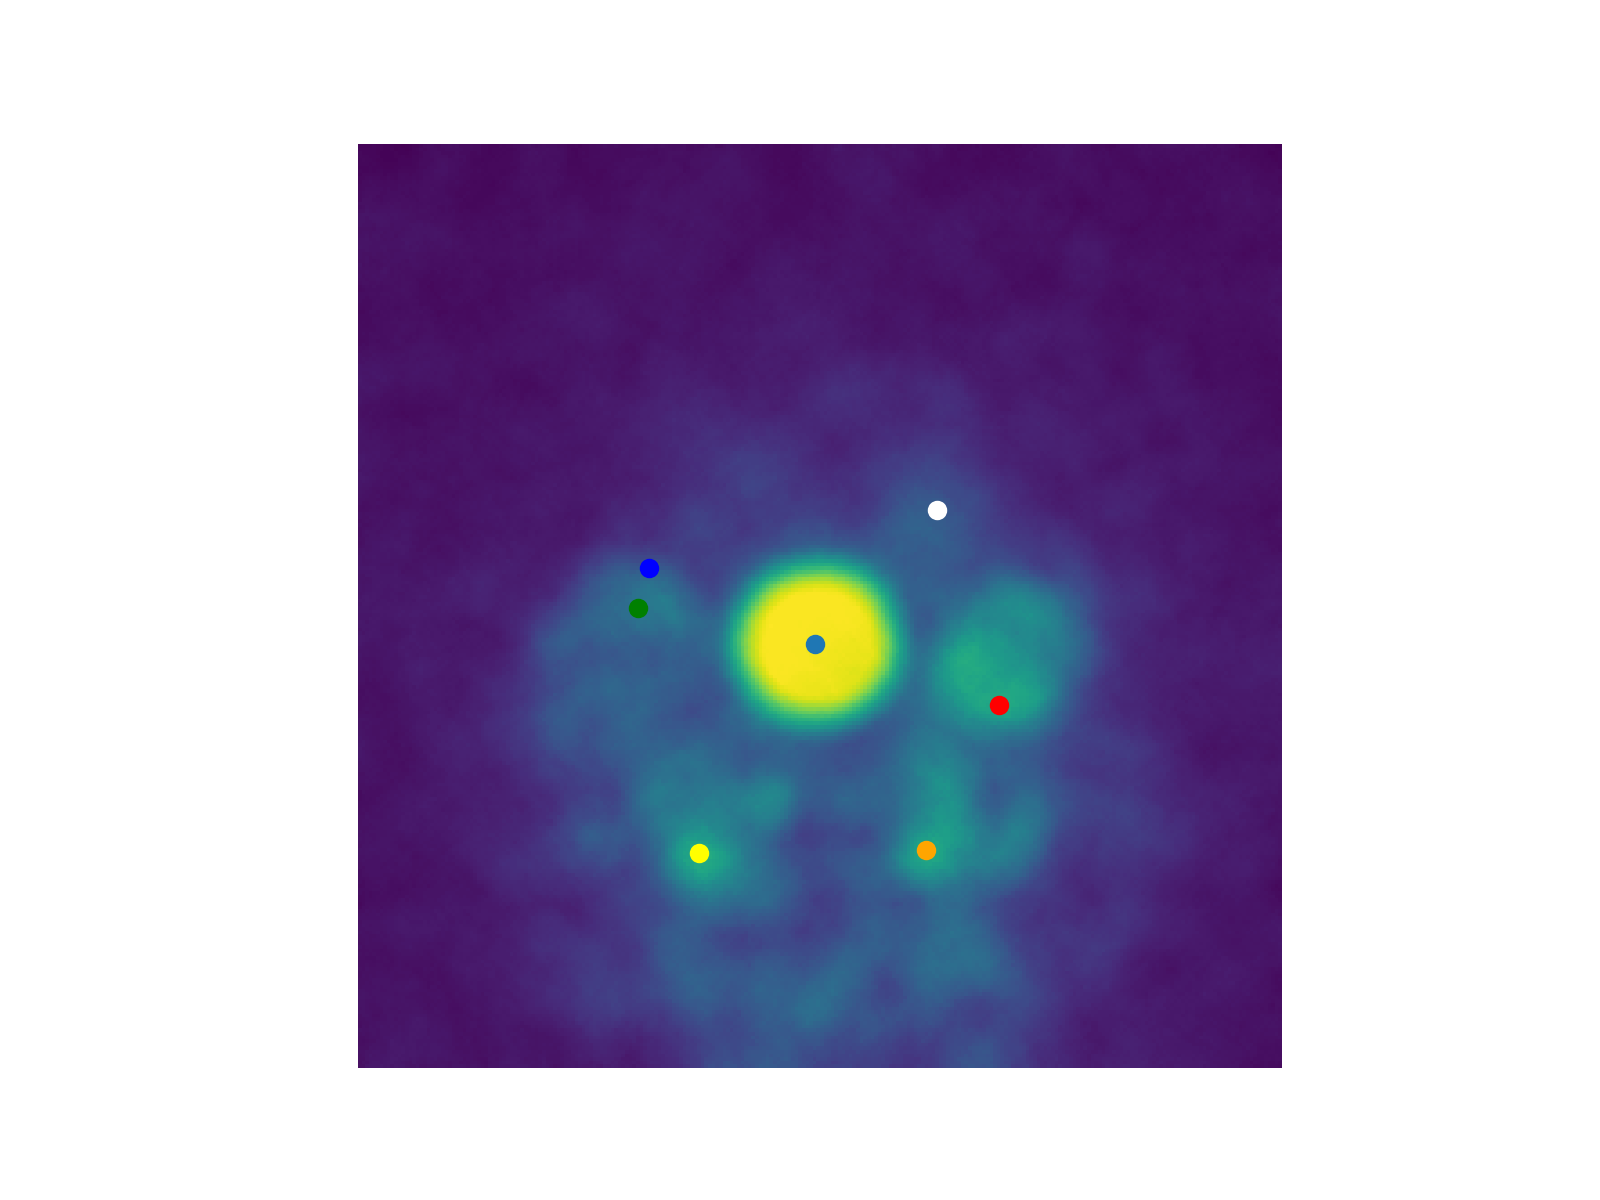

In [13]:
#i=60
#j=100
#grain nine
i=45
j=118

filtered_data=filters.rank.mean(rescale_linear(normalized_data[i,j,:,:],0,1), disk(7))

max1=np.unravel_index(np.ma.array(filtered_data, mask=~mask1_6).argmax(), filtered_data.shape)
max2=np.unravel_index(np.ma.array(filtered_data, mask=~mask2_6).argmax(), filtered_data.shape)
max3=np.unravel_index(np.ma.array(filtered_data, mask=~mask3_6).argmax(), filtered_data.shape)
max4=np.unravel_index(np.ma.array(filtered_data, mask=~mask4_6).argmax(), filtered_data.shape)
max5=np.unravel_index(np.ma.array(filtered_data, mask=~mask5_6).argmax(), filtered_data.shape)
max6=np.unravel_index(np.ma.array(filtered_data, mask=~mask6_6).argmax(), filtered_data.shape)
max1_value=np.sum(np.ma.array(filtered_data, mask=~mask1_6))
max2_value=np.sum(np.ma.array(filtered_data, mask=~mask2_6))
max3_value=np.sum(np.ma.array(filtered_data, mask=~mask3_6))
max4_value=np.sum(np.ma.array(filtered_data, mask=~mask4_6))
max5_value=np.sum(np.ma.array(filtered_data, mask=~mask5_6))
max6_value=np.sum(np.ma.array(filtered_data, mask=~mask6_6))   

print(max1_value)
print(max2_value)
print(max3_value)
print(max4_value)
print(max5_value)
print(max6_value)

fig,ax = plt.subplots(figsize=(8,6))
ax.imshow(filtered_data, cmap=plt.cm.viridis)
#ax.imshow(mask3_6, alpha=0.3)
ax.scatter(max1[1],max1[0], color='red')
ax.scatter(max2[1],max2[0], color='orange')
ax.scatter(max3[1],max3[0], color='yellow')
ax.scatter(max4[1],max4[0], color='green')
ax.scatter(max5[1],max5[0], color='blue')
ax.scatter(max6[1],max6[0], color='white')
ax.scatter(jc,ic)
ax.axis('off')
plt.show()

In [40]:
strain_matrix=np.zeros([datacube.data.shape[0],datacube.data.shape[1],3,3])
local_alpha=rescale_linear(filters.rank.mean(rescale_linear(remain,0,1), disk(2)),0,1)
remain=rescale_linear(remain,0,1)

for i in range(0,datacube.data.shape[0]):
        for j in range(0,datacube.data.shape[1]):
            xy_matrix=[[math.cos((remain[i,j]-local_alpha[i,j])*2*math.pi), math.sin((remain[i,j]-local_alpha[i,j])*2*math.pi), 0],
                      [math.sin((remain[i,j]-local_alpha[i,j])*2*math.pi), math.cos((remain[i,j]-local_alpha[i,j])*2*math.pi),0],
                        [0,0,1]]
            xz_matrix=[[math.cos(location_difference[i,j]/22*3.5/1000), 0, math.sin(location_difference[i,j]/22*3.5/1000)],
                      [0, 1, 0],
                      [math.sin(location_difference[i,j]/22*3.5/1000), 0, math.cos(location_difference[i,j]/22*3.5/1000)]]
            yz_matrix=[[1, 0, 0],
                       [0, math.cos(location_difference[i,j]/22*3.5/1000), math.sin(location_difference[i,j]/22*3.5/1000)], 
                       [0, math.sin(location_difference[i,j]/22*3.5/1000), math.cos(location_difference[i,j]/22*3.5/1000)]]
            strain_matrix[i,j,:,:]=np.dot(np.dot(xy_matrix,xz_matrix),yz_matrix)

<IPython.core.display.Javascript object>


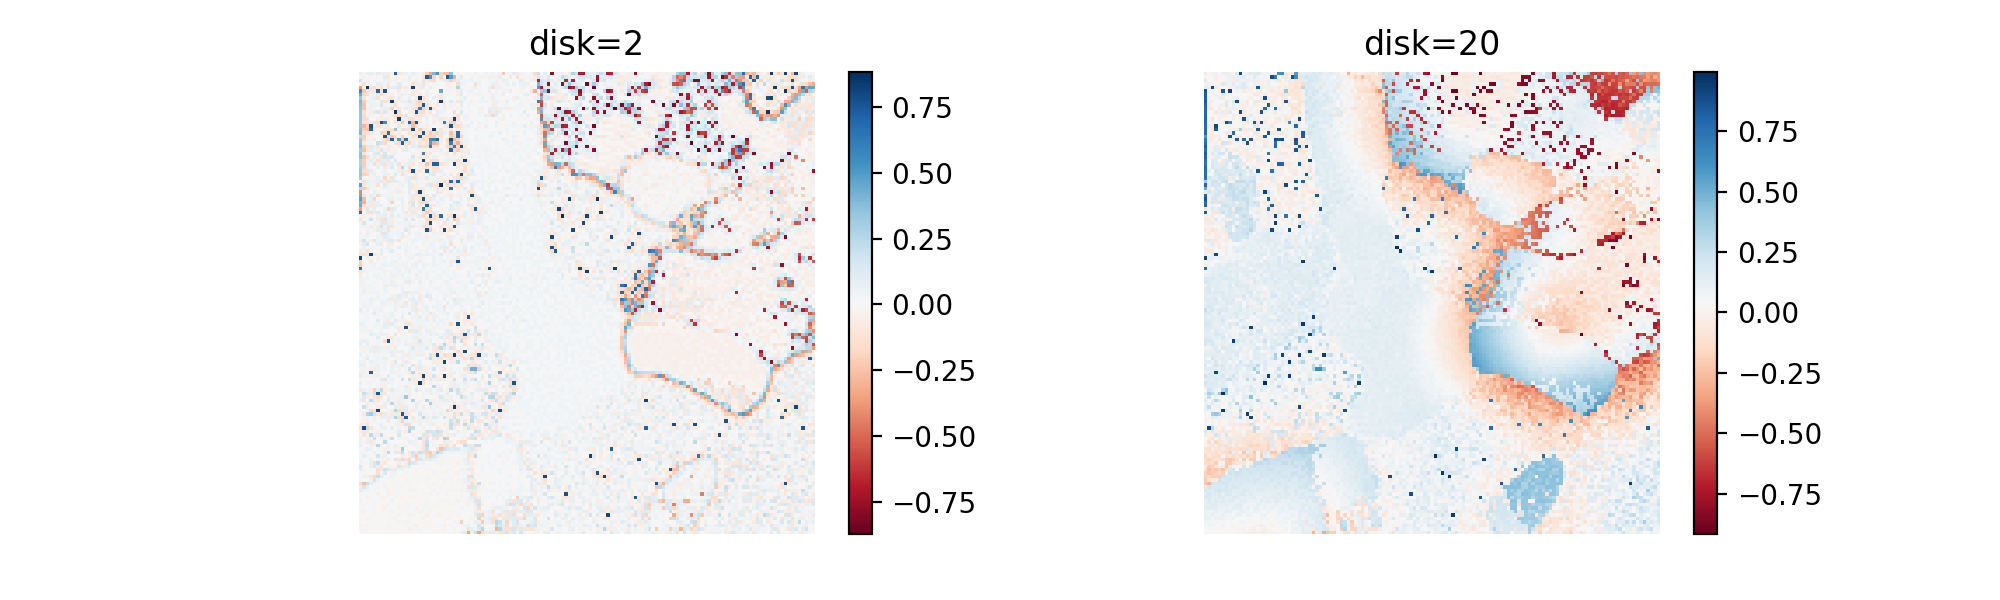

In [31]:
fig,axs = plt.subplots(1,2,figsize=(10,3))

local_alpha=rescale_linear(filters.rank.mean(rescale_linear(remain,0,1), disk(2)),0,1)

map0=axs[0].imshow(remain-local_alpha, cmap=plt.cm.RdBu)  
fig.colorbar(map0, ax=axs[0])

local_alpha=rescale_linear(filters.rank.mean(rescale_linear(remain,0,1), disk(20)),0,1)

map1=axs[1].imshow(remain-local_alpha, cmap=plt.cm.RdBu)  
fig.colorbar(map1)

axs[0].axis('off')
axs[1].axis('off')

axs[0].set_title('disk=2')
axs[1].set_title('disk=20')

plt.show()

<IPython.core.display.Javascript object>


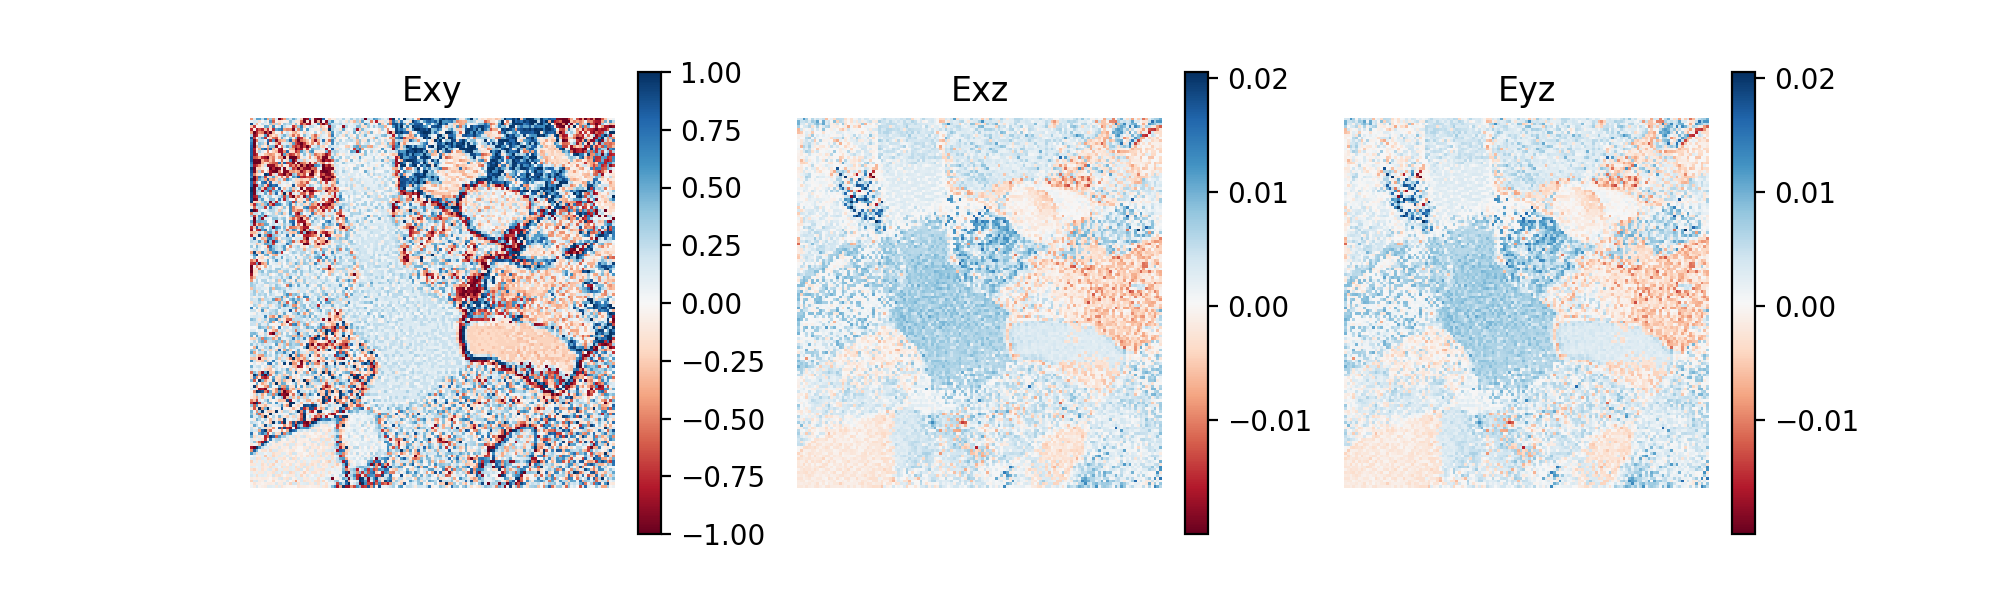

In [41]:
fig,ax = plt.subplots(1,3, figsize=(10,3))

image=ax[0].imshow(strain_matrix[:,:,0,1], cmap=plt.cm.RdBu, vmin=-1, vmax=1) 
fig.colorbar(image, ax=ax[0])
ax[0].axis('off')
ax[0].set_title('Exy')

image=ax[1].imshow(strain_matrix[:,:,0,2], cmap=plt.cm.RdBu) 
fig.colorbar(image, ax=ax[1])
ax[1].axis('off')
ax[1].set_title('Exz')

image=ax[2].imshow(strain_matrix[:,:,1,2], cmap=plt.cm.RdBu)
fig.colorbar(image, ax=ax[2])
ax[2].axis('off')
ax[2].set_title('Eyz')

plt.tight_layout
plt.show()